It is nice to be able to avoid typing something over and over - like getting `pt` into units of `GeV` in ATLAS, or defining a new computed column in your data model. There are two methods for doing this in the prototype:

1. Creating a new column in the data model using `pandas` like notation.
1. Defining a regular expression that can lead to a new column.

In [1]:
import sys
sys.path = ['..'] + sys.path
from hep_tables import xaod_table,make_local
from func_adl import EventDataset
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

In [2]:
dataset = EventDataset('localds://mc15_13TeV:mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.merge.DAOD_STDM3.e3601_s2576_s2132_r6630_r6264_p2363_tid05630052_00')
df = xaod_table(dataset)

# Adding Columns using a pandas like format

Use python's `setitem` syntax to do this, which mirrors what is done in `pandas.` Here we will define a new collection called `all_ele` that will mean we can type less, and second that will a new leaf called `mypt` which is `pt` in units of GeV.

In [3]:
df['all_ele'] = df.Electrons("Electrons")
df.all_ele['mypt'] = df.all_ele.pt / 1000.0

We can then use them as if we had the leaves or collections as reulgar parts of the event:

In [4]:
%%time
pts = make_local(df.all_ele.mypt)



Wall time: 1.9 s


i:\gwatts\code\irishep\hep_tables\.venv\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
i:\gwatts\code\irishep\hep_tables\.venv\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


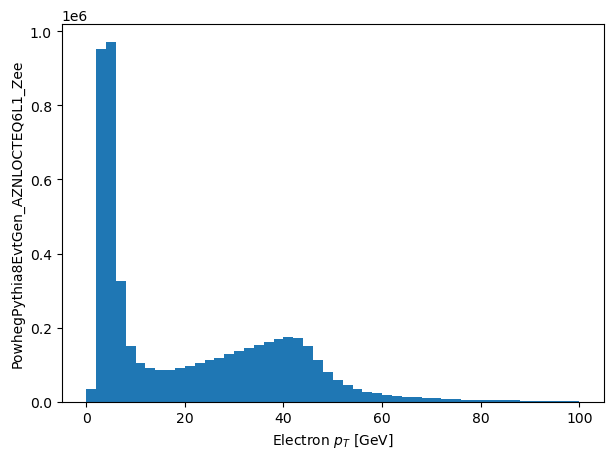

In [5]:
plt.hist(pts.flatten(), range=(0, 100), bins=50)
plt.xlabel('Electron $p_T$ [GeV]')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

As we will see in the next section, a computed column can also be a lambda expression. 

# Defining short cuts using a regular expression like syntax

This method is quite powerful and also, as a result, contains a certian amount of bad juju. Use with care!

## Defining and redefining leaves

One thing about ATLAS is that all object $p_T$'s are in units of MeV - electrons, jets muons, tracks, etc. It would be nice to redefine all references to `pt` to be in GeV. So lets define a new leaf that will always return `pt` in units of GeV no matter where it is used in the data model.

In [6]:
from dataframe_expressions import define_alias

define_alias('', 'ptgev', lambda o: o.pt / 1000.0)

In [7]:
%%time
pts = make_local(df.all_ele.ptgev)



Wall time: 1.85 s


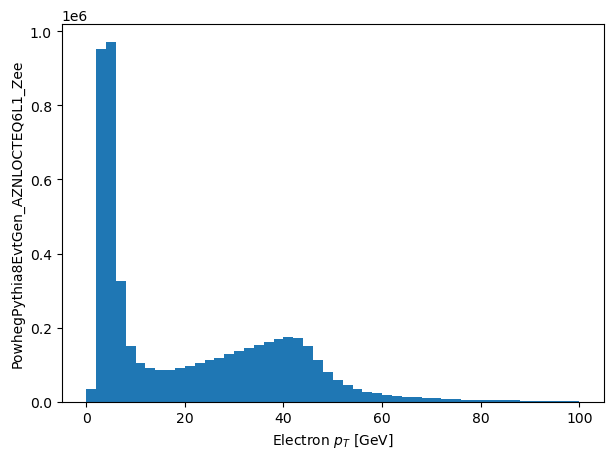

In [8]:
plt.hist(pts.flatten(), range=(0, 100), bins=50)
plt.xlabel('Electron $p_T$ [GeV]')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

The arguments to `define_alias` actually allow quite a bit more (abusive) power. The first is the root, the second is the new leaf name, and the third is the function to be applied.

## As a single leaf

This can also be used to add colunms to the data model, just as the `pandas` like method above can (the `pandas` method is the prefered way):

In [9]:
define_alias('.', 'eles', lambda e: e.Electrons("Electrons"))

In [10]:
%%time
pts = make_local(df.eles.ptgev)



Wall time: 1.84 s


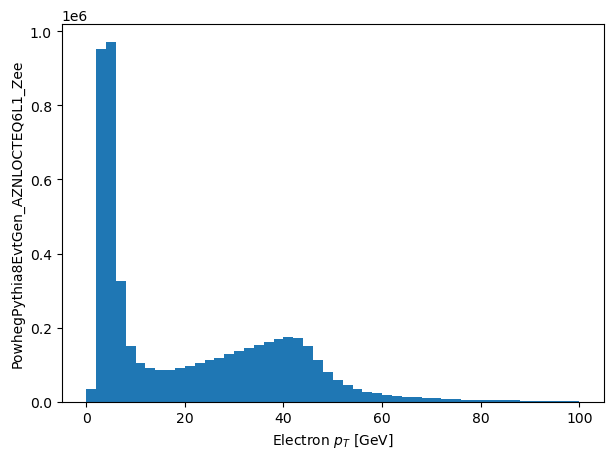

In [11]:
plt.hist(pts.flatten(), range=(0, 100), bins=50)
plt.xlabel('Electron $p_T$ [GeV]')
_ = plt.ylabel('PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee')

The help for `define_alias` gives you a few more detials if interested.

In [12]:
help(define_alias)

Help on function define_alias in module dataframe_expressions.alias:

define_alias(base_obj: 'str', name: 'str', func_define: 'Callable[[DataFrame], DataFrame]')
    Define an alias that can be used as a short cut for a reference later on. For example:
    
        ```
        df = DataFrame()
        define_alias (".jets", "pts", lambda o: o.pt/1000.0)
        ```
    
    When you write `df.jets.pts` it is the same as writing `df.jets.pt/1000.0`.
    
    If you've already used an alias in constructing a `DataFrame` then it will not be
    filled: alias are resolved as the DAG is being constructed, not when it is rendered.
    
    ## Adding aliases of the same name
    
    This implementation does no checking as things are added. You can have different base names,
    and if the base_obj's are different they will match differently, as you would expect.
    But they are evaluated last one entered first, so if you enter a complete wildcard, nothing
    else will ever get looked at. I